# Beta Correction to the Dicke Narrowing

Dicke narrowing accounts for effective narrowing of the doppler width because of velocity changing collisions.  The magnitude of this effect is dependent on the hardness of the collisions.  Different line shapes make different assumptions on the hardness of the collision with the Nelkhin-Ghatak making the assumption that collisions are hard, meaning that the the molecular velocity before a collision are forgotten after the collision, and  the Galatry profile assuming collisions are soft, meaning that many collisions are necessary to change the velocity. In reality, the hardness of the collision is related to the perturbers and absorbers being studied.  In the paper below, authors map the hard Dicke Narrowing term onto the billiard ball collision model, based on a parameter beta, which is related to the pressure (parameterized as the Dicke narrowing at a pressure relative to the doppler width) and the ratio of the masses between the perturber and absorber.  As Beta can be calculated, this correction provides a more robust modeling of the Dicke Narrowing without the addition of additional floated parameters. 

M. Konefał, M. Słowiński, M. Zaborowski, R. Ciuryło, D. Lisak, P. Wcisło, Analytical-function correction to the Hartmann–Tran profile for more reliable representation of the Dicke-narrowed molecular spectra, Journal of Quantitative Spectroscopy and Radiative Transfer, Volume 242, 2020,106784,ISSN 0022-4073, https://doi.org/10.1016/j.jqsrt.2019.106784.

The Beta correction has been included in the MATS software and the following example provides an example of how to use it. 

In [1]:
# Load Necessary Packages

import numpy as np
import pandas as pd
import qgrid
import os, sys
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

sys.path.append(r'C:\Users\ema3\Documents\MATS\MATS')# set location of HAPI.py module

from MATS import *



HAPI version: 1.1.0.9.6
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2017 are now available in HAPI code

           It is free to use HAPI. If you use HAPI in your research or software development,
           please cite it using the following reference:
           R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski,
           HITRAN Application Programming Interface (HAPI): A comprehensive approach
           to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
           DOI: 10.1016/j.jqsrt.2016.03.005


## Simulate Spectra with Beta Parameter

For the purpose of showing the mechanism, we will be simulating data for CO$_{2}$, air, and 10% CO$_{2}$ in air samples between 1 and 500 torr.  The structure of the script follows that outlined in the A-Band synthetic spectra example.  

After the generic parameters are introduce the line list for simulations is read in.  In this example we are making some adjustments to the line list before simulating.  In the MATS fitting, simulations are only conducted to some user-defined range outside of the spectral frequency range (wave_range = 1.5 cm$^{-1}$ in the current example).  This same constraint is not imposed when simulating spectra.  This can lead to some far-wing issues between simulation and fitting if care is not taken to match the wave_range to the lines in the parameter linelist and the simulation wing_cutoff magnitude, which should also match the fit wing_cutoff magnitude.  For this example, we are truncating the simulation line list to [wave_min - wave_range, wave_max + wave_range].  Additionally, values for the Dicke Narrowing air and selve parameters are set and the line mixing terms are set to 0.

The simulate_spectrum() definition is used to generate several spectrum class objects.  The beta_formalism variable is set to true, which simulates the spectra accounting for the change in Dicke Narrowing with the hardness of the collision.  The synthetic spectra span 3 samples: CO$_{2}$, air, and 10% CO$_{2}$ in air.  The air and CO$_{2}$ samples can use the diluent = 'air' and 'self' variables as the Diluent variable can be auto-generated.  However, the 10% CO$_{2}$ in air sample requires the explicit definition of the Diluent variable, which is a dictionary of dictionaries where for each diluent a dictionary with composition and mass (m) keys.  This allows the calculation of the mass of perturber, which is necessary for the Beta implementation.  



In [2]:
#Simulate Spectra including with Beta.  

path = r'C:\Users\ema3\Documents\MATS\MATS\Examples\Beta_Parameterization'
os.chdir(path)

#Generic Fit Parameters
wave_range = 1.5 #range outside of experimental x-range to simulate
IntensityThreshold = 1e-30 #intensities must be above this value to be simulated
Fit_Intensity = 1e-25 #intensities must be above this value for the line to be fit
order_baseline_fit = 1
wave_min = 6326 #cm-1
wave_max = 6328 #cm-1
wave_space = 0.005 #cm-1
baseline_terms = [0] #polynomial baseline coefficients where the index is equal to the coefficient order
etalon = {}

#Read in  linelists
hapi = r'C:\Users\ema3\Documents\MATS\MATS\Linelists'
os.chdir(hapi)
##Adjust the linelist before simualting spectra
PARAM_LINELIST = pd.read_csv('CO2_30012.csv')
PARAM_LINELIST = PARAM_LINELIST[(PARAM_LINELIST['nu']>= wave_min - wave_range) & (PARAM_LINELIST['nu']<= wave_min + wave_range)]
PARAM_LINELIST.loc[(PARAM_LINELIST['sw'] > Fit_Intensity)& (PARAM_LINELIST['local_iso_id'] == 1) & (PARAM_LINELIST['molec_id'] == 2), 'nuVC_air'] = 0.018596 
PARAM_LINELIST.loc[(PARAM_LINELIST['sw'] > Fit_Intensity) & (PARAM_LINELIST['local_iso_id'] == 1) & (PARAM_LINELIST['molec_id'] == 2), 'nuVC_self'] = 0.01993
PARAM_LINELIST.loc[(PARAM_LINELIST['sw'] > Fit_Intensity) & (PARAM_LINELIST['local_iso_id'] == 1) & (PARAM_LINELIST['molec_id'] == 2), 'y_self_296'] = 0
PARAM_LINELIST.loc[(PARAM_LINELIST['sw'] > Fit_Intensity) & (PARAM_LINELIST['local_iso_id'] == 1) & (PARAM_LINELIST['molec_id'] == 2), 'y_air_296'] = 0

os.chdir(path)

##SNR
SNR = 50000
wave_error = 0


#Synthetic Air Simulation
print ('Synthetic Air Samples')
spec_1 =  simulate_spectrum(PARAM_LINELIST, wave_min, wave_max, wave_space, wave_error = wave_error, 
                        SNR = SNR, baseline_terms = baseline_terms, temperature = 25, pressure = 1, diluent = 'air',filename = 'Air_1_torr',
                        wing_cutoff = 25, wing_method = 'wing_wavenumbers',  molefraction = {2 :400*1e-6}, 
                        etalons = etalon, natural_abundance = True, nominal_temperature = 296, IntensityThreshold = 1e-30, num_segments = 1, beta_formalism = True)
spec_2 =  simulate_spectrum(PARAM_LINELIST, wave_min, wave_max, wave_space, wave_error = wave_error, 
                        SNR = SNR, baseline_terms = baseline_terms, temperature = 25, pressure = 10, diluent = 'air',filename = 'Air_10_torr',
                        wing_cutoff = 25, wing_method = 'wing_wavenumbers',  molefraction = {2 :400*1e-6}, 
                        etalons = etalon, natural_abundance = True, nominal_temperature = 296, IntensityThreshold = 1e-30, num_segments = 1, beta_formalism = True)
spec_3 =  simulate_spectrum(PARAM_LINELIST, wave_min, wave_max, wave_space, wave_error = wave_error, 
                        SNR = SNR, baseline_terms = baseline_terms, temperature = 25, pressure = 100, diluent = 'air',filename = 'Air_100_torr',
                        wing_cutoff = 25, wing_method = 'wing_wavenumbers', molefraction = {2 :400*1e-6}, 
                        etalons = etalon, natural_abundance = True, nominal_temperature = 296, IntensityThreshold = 1e-30, num_segments = 1, beta_formalism = True)
spec_4 =  simulate_spectrum(PARAM_LINELIST, wave_min, wave_max, wave_space, wave_error = wave_error, 
                        SNR = SNR, baseline_terms = baseline_terms, temperature = 25, pressure = 250, diluent = 'air',filename = 'Air_250_torr',
                        wing_cutoff = 25, wing_method = 'wing_wavenumbers', molefraction = {2 :400*1e-6}, 
                        etalons = etalon, natural_abundance = True, nominal_temperature = 296, IntensityThreshold = 1e-30, num_segments = 1, beta_formalism = True)
spec_5 =  simulate_spectrum(PARAM_LINELIST, wave_min, wave_max, wave_space, wave_error = wave_error, 
                        SNR = SNR, baseline_terms = baseline_terms, temperature = 25, pressure = 500, diluent = 'air',filename = 'Air_500_torr',
                       wing_cutoff = 25, wing_method = 'wing_wavenumbers',  molefraction = {2 :400*1e-6}, 
                        etalons = etalon, natural_abundance = True, nominal_temperature = 296, IntensityThreshold = 1e-30, num_segments = 1, beta_formalism = True)
#Mixture of CO2 and Air
## Note that we had to use the Diluent method opposedc to the diluent method.  Additionally, the use of the self broadening term will generate some warnings
print ('Mixture Samples')
spec_6 =  simulate_spectrum(PARAM_LINELIST, wave_min, wave_max, wave_space, wave_error = wave_error, 
                        SNR = SNR, baseline_terms = baseline_terms, temperature = 25, pressure = 1, filename = 'Mix_1_torr',
                        Diluent = {'self':{'composition':0.1, 'm':43.98983} , 'air' :{'composition':0.9, 'm':28.95734}},
                        wing_cutoff = 25, wing_method = 'wing_wavenumbers',  molefraction = {2 :0.1}, 
                        etalons = etalon, natural_abundance = True, nominal_temperature = 296, IntensityThreshold = 1e-30, num_segments = 1, beta_formalism = True)
spec_7=  simulate_spectrum(PARAM_LINELIST, wave_min, wave_max, wave_space, wave_error = wave_error, 
                        SNR = SNR, baseline_terms = baseline_terms, temperature = 25, pressure = 10, filename = 'Mix_10_torr',
                        Diluent = {'self':{'composition':0.1, 'm':43.98983} , 'air' :{'composition':0.9, 'm':28.95734}},
                        wing_cutoff = 25, wing_method = 'wing_wavenumbers',  molefraction = {2 :0.1}, 
                        etalons = etalon, natural_abundance = True, nominal_temperature = 296, IntensityThreshold = 1e-30, num_segments = 1, beta_formalism = True)
spec_8 =  simulate_spectrum(PARAM_LINELIST, wave_min, wave_max, wave_space, wave_error = wave_error, 
                        SNR = SNR, baseline_terms = baseline_terms, temperature = 25, pressure = 100, filename = 'Mix_100_torr',
                        Diluent = {'self':{'composition':0.1, 'm':43.98983} , 'air' :{'composition':0.9, 'm':28.95734}},
                        wing_cutoff = 25, wing_method = 'wing_wavenumbers',  molefraction = {2 :0.1}, 
                        etalons = etalon, natural_abundance = True, nominal_temperature = 296, IntensityThreshold = 1e-30, num_segments = 1, beta_formalism = True)
spec_9 =  simulate_spectrum(PARAM_LINELIST, wave_min, wave_max, wave_space, wave_error = wave_error, 
                        SNR = SNR, baseline_terms = baseline_terms, temperature = 25, pressure = 250,filename = 'Mix_250_torr',
                        Diluent = {'self':{'composition':0.1, 'm':43.98983} , 'air' :{'composition':0.9, 'm':28.95734}}, 
                        wing_cutoff = 25, wing_method = 'wing_wavenumbers', molefraction = {2 :0.1}, 
                        etalons = etalon, natural_abundance = True, nominal_temperature = 296, IntensityThreshold = 1e-30, num_segments = 1, beta_formalism = True)
spec_10 =  simulate_spectrum(PARAM_LINELIST, wave_min, wave_max, wave_space, wave_error = wave_error, 
                        SNR = SNR, baseline_terms = baseline_terms, temperature = 25, pressure = 500, filename = 'Mix_500_torr',
                             Diluent = {'self':{'composition':0.1, 'm':43.98983} , 'air' :{'composition':0.9, 'm':28.95734}}, 
                        wing_cutoff = 25, wing_method = 'wing_wavenumbers', molefraction = {2 :0.1}, 
                        etalons = etalon, natural_abundance = True, nominal_temperature = 296, IntensityThreshold = 1e-30, num_segments = 1, beta_formalism = True)   

#Pure CO2.  Notice that the use of the self broadening term will cause some warnings.
print ('Pure CO2 Samples')
spec_11 =  simulate_spectrum(PARAM_LINELIST, wave_min, wave_max, wave_space, wave_error = wave_error, 
                        SNR = SNR, baseline_terms = baseline_terms, temperature = 25, pressure = 1, diluent = 'self', filename = 'CO2_1_torr',
                        wing_cutoff = 25, wing_method = 'wing_wavenumbers',  molefraction = {2 :1}, 
                        etalons = etalon, natural_abundance = True, nominal_temperature = 296, IntensityThreshold = 1e-30, num_segments = 1, beta_formalism = True)
spec_12 =  simulate_spectrum(PARAM_LINELIST, wave_min, wave_max, wave_space, wave_error = wave_error, 
                        SNR = SNR, baseline_terms = baseline_terms, temperature = 25, pressure = 10, diluent = 'self',filename = 'CO2_10_torr',
                        wing_cutoff = 25, wing_method = 'wing_wavenumbers',  molefraction = {2 :1}, 
                        etalons = etalon, natural_abundance = True, nominal_temperature = 296, IntensityThreshold = 1e-30, num_segments = 1, beta_formalism = True)
spec_13 =  simulate_spectrum(PARAM_LINELIST, wave_min, wave_max, wave_space, wave_error = wave_error, 
                        SNR = SNR, baseline_terms = baseline_terms, temperature = 25, pressure = 100, diluent = 'self',filename = 'CO2_100_torr',
                        wing_cutoff = 25, wing_method = 'wing_wavenumbers',  molefraction = {2 :1}, 
                        etalons = etalon, natural_abundance = True, nominal_temperature = 296, IntensityThreshold = 1e-30, num_segments = 1, beta_formalism = True)
spec_14 =  simulate_spectrum(PARAM_LINELIST, wave_min, wave_max, wave_space, wave_error = wave_error, 
                        SNR = SNR, baseline_terms = baseline_terms, temperature = 25, pressure = 250,  diluent = 'self', filename = 'CO2_250_torr',
                        wing_cutoff = 25, wing_method = 'wing_wavenumbers', molefraction = {2 :1}, 
                        etalons = etalon, natural_abundance = True, nominal_temperature = 296, IntensityThreshold = 1e-30, num_segments = 1, beta_formalism = True)
spec_15 =  simulate_spectrum(PARAM_LINELIST, wave_min, wave_max, wave_space, wave_error = wave_error, 
                        SNR = SNR, baseline_terms = baseline_terms, temperature = 25, pressure = 500,  diluent = 'self', filename = 'CO2_500_torr',
                        wing_cutoff = 25, wing_method = 'wing_wavenumbers', molefraction = {2 :1}, 
                        etalons = etalon, natural_abundance = True, nominal_temperature = 296, IntensityThreshold = 1e-30, num_segments = 1, beta_formalism = True)                       



Synthetic Air Samples


C:\Users\ema3\Documents\MATS\MATS\Fit_Dataset.py:384: RuntimeWarning: divide by zero encountered in log10
  linelist['Beta'] = linelist['A'].values*np.tanh(linelist['B'].values * np.log10(linelist['Chi'].values) + linelist['C'].values) + linelist['D'].values
C:\Users\ema3\Documents\MATS\MATS\Fit_Dataset.py:384: RuntimeWarning: divide by zero encountered in log10
  linelist['Beta'] = linelist['A'].values*np.tanh(linelist['B'].values * np.log10(linelist['Chi'].values) + linelist['C'].values) + linelist['D'].values
C:\Users\ema3\Documents\MATS\MATS\Fit_Dataset.py:384: RuntimeWarning: divide by zero encountered in log10
  linelist['Beta'] = linelist['A'].values*np.tanh(linelist['B'].values * np.log10(linelist['Chi'].values) + linelist['C'].values) + linelist['D'].values
C:\Users\ema3\Documents\MATS\MATS\Fit_Dataset.py:384: RuntimeWarning: divide by zero encountered in log10
  linelist['Beta'] = linelist['A'].values*np.tanh(linelist['B'].values * np.log10(linelist['Chi'].values) + linelist[

Mixture Samples
You are using the 'self' term, consider explicitly labeling the broadener (ie in an oxygen spectra use 'O2' instead of 'self').  This may avoid confusion in multiple species fits. For single species fits it should not matter.
Double check that you did not include the equivalent of the self term explicitly (ie in an oxygen spectra having both 'O2' and 'self').
You are using the 'self' term, consider explicitly labeling the broadener (ie in an oxygen spectra use 'O2' instead of 'self').  This may avoid confusion in multiple species fits. For single species fits it should not matter.
Double check that you did not include the equivalent of the self term explicitly (ie in an oxygen spectra having both 'O2' and 'self').


C:\Users\ema3\Documents\MATS\MATS\Fit_Dataset.py:384: RuntimeWarning: divide by zero encountered in log10
  linelist['Beta'] = linelist['A'].values*np.tanh(linelist['B'].values * np.log10(linelist['Chi'].values) + linelist['C'].values) + linelist['D'].values
C:\Users\ema3\Documents\MATS\MATS\Fit_Dataset.py:384: RuntimeWarning: divide by zero encountered in log10
  linelist['Beta'] = linelist['A'].values*np.tanh(linelist['B'].values * np.log10(linelist['Chi'].values) + linelist['C'].values) + linelist['D'].values
C:\Users\ema3\Documents\MATS\MATS\Fit_Dataset.py:384: RuntimeWarning: divide by zero encountered in log10
  linelist['Beta'] = linelist['A'].values*np.tanh(linelist['B'].values * np.log10(linelist['Chi'].values) + linelist['C'].values) + linelist['D'].values


You are using the 'self' term, consider explicitly labeling the broadener (ie in an oxygen spectra use 'O2' instead of 'self').  This may avoid confusion in multiple species fits. For single species fits it should not matter.
Double check that you did not include the equivalent of the self term explicitly (ie in an oxygen spectra having both 'O2' and 'self').
You are using the 'self' term, consider explicitly labeling the broadener (ie in an oxygen spectra use 'O2' instead of 'self').  This may avoid confusion in multiple species fits. For single species fits it should not matter.
Double check that you did not include the equivalent of the self term explicitly (ie in an oxygen spectra having both 'O2' and 'self').


C:\Users\ema3\Documents\MATS\MATS\Fit_Dataset.py:384: RuntimeWarning: divide by zero encountered in log10
  linelist['Beta'] = linelist['A'].values*np.tanh(linelist['B'].values * np.log10(linelist['Chi'].values) + linelist['C'].values) + linelist['D'].values
C:\Users\ema3\Documents\MATS\MATS\Fit_Dataset.py:384: RuntimeWarning: divide by zero encountered in log10
  linelist['Beta'] = linelist['A'].values*np.tanh(linelist['B'].values * np.log10(linelist['Chi'].values) + linelist['C'].values) + linelist['D'].values


You are using the 'self' term, consider explicitly labeling the broadener (ie in an oxygen spectra use 'O2' instead of 'self').  This may avoid confusion in multiple species fits. For single species fits it should not matter.
Double check that you did not include the equivalent of the self term explicitly (ie in an oxygen spectra having both 'O2' and 'self').
Pure CO2 Samples
You are using the 'self' term, consider explicitly labeling the broadener (ie in an oxygen spectra use 'O2' instead of 'self').  This may avoid confusion in multiple species fits. For single species fits it should not matter.
Double check that you did not include the equivalent of the self term explicitly (ie in an oxygen spectra having both 'O2' and 'self').
You are using the 'self' term, consider explicitly labeling the broadener (ie in an oxygen spectra use 'O2' instead of 'self').  This may avoid confusion in multiple species fits. For single species fits it should not matter.
Double check that you did not inc

C:\Users\ema3\Documents\MATS\MATS\Fit_Dataset.py:384: RuntimeWarning: divide by zero encountered in log10
  linelist['Beta'] = linelist['A'].values*np.tanh(linelist['B'].values * np.log10(linelist['Chi'].values) + linelist['C'].values) + linelist['D'].values
C:\Users\ema3\Documents\MATS\MATS\Fit_Dataset.py:384: RuntimeWarning: divide by zero encountered in log10
  linelist['Beta'] = linelist['A'].values*np.tanh(linelist['B'].values * np.log10(linelist['Chi'].values) + linelist['C'].values) + linelist['D'].values


You are using the 'self' term, consider explicitly labeling the broadener (ie in an oxygen spectra use 'O2' instead of 'self').  This may avoid confusion in multiple species fits. For single species fits it should not matter.
Double check that you did not include the equivalent of the self term explicitly (ie in an oxygen spectra having both 'O2' and 'self').
You are using the 'self' term, consider explicitly labeling the broadener (ie in an oxygen spectra use 'O2' instead of 'self').  This may avoid confusion in multiple species fits. For single species fits it should not matter.
Double check that you did not include the equivalent of the self term explicitly (ie in an oxygen spectra having both 'O2' and 'self').


C:\Users\ema3\Documents\MATS\MATS\Fit_Dataset.py:384: RuntimeWarning: divide by zero encountered in log10
  linelist['Beta'] = linelist['A'].values*np.tanh(linelist['B'].values * np.log10(linelist['Chi'].values) + linelist['C'].values) + linelist['D'].values
C:\Users\ema3\Documents\MATS\MATS\Fit_Dataset.py:384: RuntimeWarning: divide by zero encountered in log10
  linelist['Beta'] = linelist['A'].values*np.tanh(linelist['B'].values * np.log10(linelist['Chi'].values) + linelist['C'].values) + linelist['D'].values


You are using the 'self' term, consider explicitly labeling the broadener (ie in an oxygen spectra use 'O2' instead of 'self').  This may avoid confusion in multiple species fits. For single species fits it should not matter.
Double check that you did not include the equivalent of the self term explicitly (ie in an oxygen spectra having both 'O2' and 'self').


## Generate a Dataset

In [3]:

#Add all spectrum to a Dataset object
os.chdir(path)
SPECTRA = Dataset([spec_1, spec_2, spec_3, spec_4, spec_5, spec_6, spec_7, spec_8, spec_9, spec_10, spec_11, spec_12, spec_13, spec_14, spec_15], 'CO2 Study',PARAM_LINELIST ) 

#Generate Baseline Parameter list based on number of etalons in spectra definitions and baseline order
BASE_LINELIST = SPECTRA.generate_baseline_paramlist()


## Generate Fit Parameter Files

In [4]:
os.chdir(path)
# Set-up for Fitting
#lineprofile = 'NGP' #VP, SDVP, NGP, SDNGP, HTP


FITPARAMS = Generate_FitParam_File(SPECTRA, PARAM_LINELIST, BASE_LINELIST, lineprofile = 'SDNGP', linemixing = False, 
                                  fit_intensity = Fit_Intensity, threshold_intensity = IntensityThreshold, sim_window = wave_range,
                                  nu_constrain = True, sw_constrain = True, gamma0_constrain = True, delta0_constrain = True, 
                                   aw_constrain = True, as_constrain = True, 
                                   nuVC_constrain = True, eta_constrain =True, linemixing_constrain = True)
                                  #additional_columns = ['trans_id', 'local_lower_quanta', 'm'])

FITPARAMS.generate_fit_param_linelist_from_linelist(vary_nu = {2:{1:True, 2:False, 3:False}}, vary_sw = {2:{1:True, 2:False, 3:False}},
                                                    vary_gamma0 = {2:{1: True, 2:False, 3: False}, 1:{1:False}}, vary_n_gamma0 = {2:{1:False}}, 
                                                    vary_delta0 = {2:{1: True, 2:False, 3: False}, 1:{1:False}}, vary_n_delta0 = {2:{1:False}}, 
                                                    vary_aw = {2:{1: True, 2:False, 3: False}, 1:{1:False}}, vary_n_gamma2 = {2:{1:False}}, 
                                                    vary_as = {}, vary_n_delta2 = {2:{1:False}}, 
                                                    vary_nuVC = {2:{1:True}}, vary_n_nuVC = {2:{1:False}},
                                                    vary_eta = {}, vary_linemixing = {2:{1:False}})

FITPARAMS.generate_fit_baseline_linelist(vary_baseline = False, vary_molefraction = {7:False, 1:False}, vary_xshift = False, 
                                      vary_etalon_amp= False, vary_etalon_period= False, vary_etalon_phase= False)

,Segment Number,Pressure,Pressure_err,Pressure_vary,Temperature,Temperature_err,Temperature_vary,baseline_a,baseline_a_err,baseline_a_vary,molefraction_CO2,molefraction_CO2_err,molefraction_CO2_vary,x_shift,x_shift_err,x_shift_vary
Spectrum Number,,,,,,,,,,,,,,,,
1.0,0.0,0.001316,0,False,298.15,0,False,0.0,0,False,0.0004,0,False,0.0,0,False
2.0,0.0,0.013158,0,False,298.15,0,False,0.0,0,False,0.0004,0,False,0.0,0,False
3.0,0.0,0.131579,0,False,298.15,0,False,0.0,0,False,0.0004,0,False,0.0,0,False
4.0,0.0,0.328947,0,False,298.15,0,False,0.0,0,False,0.0004,0,False,0.0,0,False
5.0,0.0,0.657895,0,False,298.15,0,False,0.0,0,False,0.0004,0,False,0.0,0,False
6.0,0.0,0.001316,0,False,298.15,0,False,0.0,0,False,0.1000,0,False,0.0,0,False
7.0,0.0,0.013158,0,False,298.15,0,False,0.0,0,False,0.1000,0,False,0.0,0,False
8.0,0.0,0.131579,0,False,298.15,0,False,0.0,0,False,0.1000,0,False,0.0,0,False
9.0,0.0,0.328947,0,False,298.15,0,False,0.0,0,False,0.1000,0,False,0.0,0,False


## Fit Dataset

In this first example, we are fitting the data without including the beta_formalism to correct for the hardness of the collisions by setting the beta_formalism to False in the Fit_Dataset instance, which is the default.  The results show systematic residuals at the line core based on the large range of pressures.  



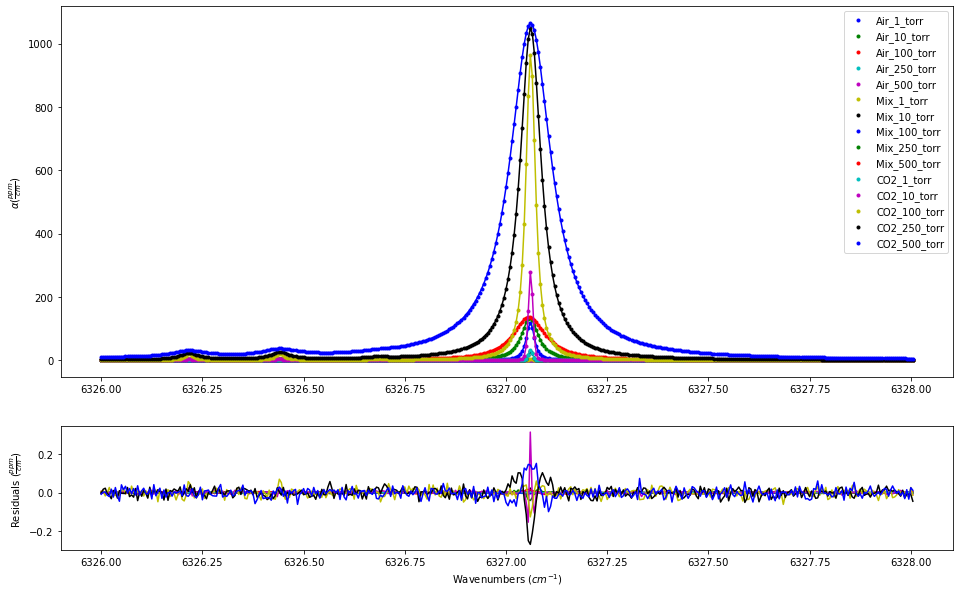

In [5]:
os.chdir(path)   
fit_data = Fit_DataSet(SPECTRA,'Baseline_LineList', 'Parameter_LineList', minimum_parameter_fit_intensity = 1e-24, 
                      beta_formalism = False)
params = fit_data.generate_params()
result = fit_data.fit_data(params, wing_cutoff = 25,wing_method = 'wing_wavenumbers')
#print (result.params.pretty_print())

fit_data.residual_analysis(result, indv_resid_plot=False)
fit_data.update_params(result, param_linelist_update_file = 'Results without Beta')
SPECTRA.generate_summary_file(save_file = True)
SPECTRA.plot_model_residuals()



In the second example, the beta formalism term is set to True.  Unsuprisingly, using the beta correction gives better results as this is how the spectra were simulated. 

The generate_beta_output_file() definition can be used to tabulate a value of the beta parameters that are used for all lines and each spectrum. By default this is saved in a file called Beta Summary File.csv.  The second plot shows how this $\beta$ parameter changes with sample and pressure

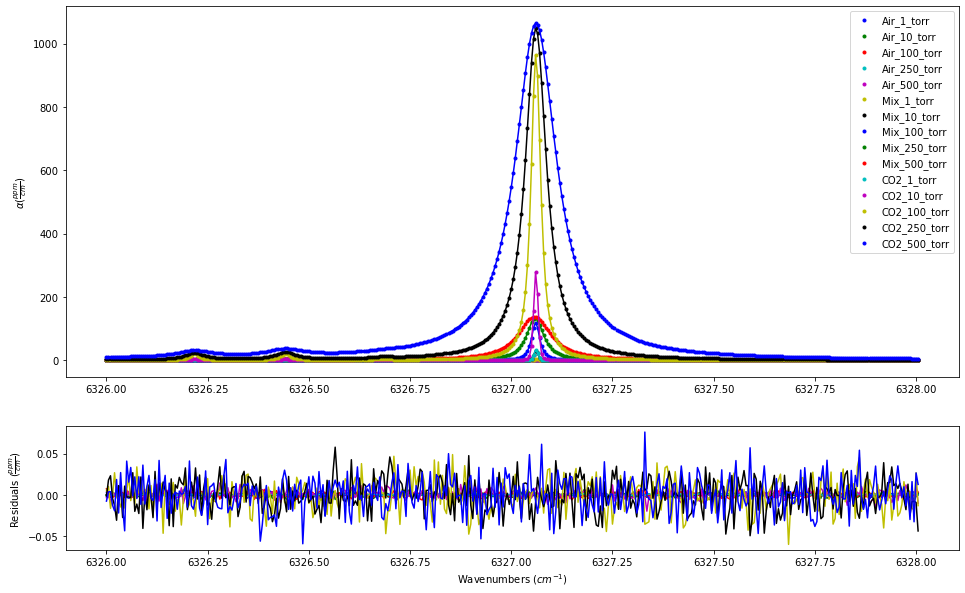

C:\Users\ema3\Anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\ema3\Anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\ema3\Anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\ema3\Anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\ema3\Anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\ema3\Anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered 

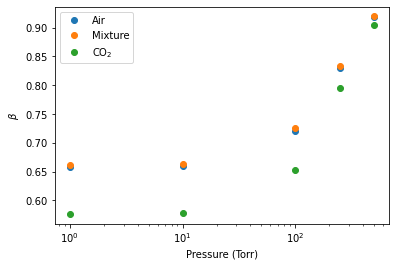

In [6]:

os.chdir(path)   
fit_data = Fit_DataSet(SPECTRA,'Baseline_LineList', 'Parameter_LineList', minimum_parameter_fit_intensity = 1e-24, 
                      beta_formalism = True)
params = fit_data.generate_params()
result = fit_data.fit_data(params, wing_cutoff = 25,wing_method = 'wing_wavenumbers')
#print (result.params.pretty_print())

fit_data.residual_analysis(result, indv_resid_plot=False)
fit_data.update_params(result)
SPECTRA.generate_summary_file(save_file = True)
SPECTRA.plot_model_residuals()
fit_data.generate_beta_output_file()

beta_summary_file = pd.read_csv('Beta Summary File.csv', index_col = 0)
beta_summary_file[beta_summary_file['nuVC_air_vary']==True]

pressures = [1,10, 100, 250, 500]
air_beta = [beta_summary_file[beta_summary_file.index == 62]['Beta_1'].values[0], beta_summary_file[beta_summary_file.index == 62]['Beta_2'].values[0], beta_summary_file[beta_summary_file.index == 62]['Beta_3'].values[0], 
            beta_summary_file[beta_summary_file.index == 62]['Beta_4'].values[0], beta_summary_file[beta_summary_file.index == 62]['Beta_5'].values[0]]
mix_beta = [beta_summary_file[beta_summary_file.index == 62]['Beta_6'].values[0], beta_summary_file[beta_summary_file.index == 62]['Beta_7'].values[0], beta_summary_file[beta_summary_file.index == 62]['Beta_8'].values[0], 
            beta_summary_file[beta_summary_file.index == 62]['Beta_9'].values[0], beta_summary_file[beta_summary_file.index == 62]['Beta_10'].values[0]]
CO2_beta = [beta_summary_file[beta_summary_file.index == 62]['Beta_11'].values[0], beta_summary_file[beta_summary_file.index == 62]['Beta_12'].values, beta_summary_file[beta_summary_file.index == 62]['Beta_13'].values[0], 
            beta_summary_file[beta_summary_file.index == 62]['Beta_14'].values[0], beta_summary_file[beta_summary_file.index == 62]['Beta_15'].values[0]]

plt.semilogx(pressures, air_beta, 'o', label = 'Air')
plt.semilogx(pressures, mix_beta, 'o', label = 'Mixture')
plt.semilogx(pressures, CO2_beta, 'o', label = 'CO$_{2}$')
plt.xlabel('Pressure (Torr)')
plt.ylabel('$\\beta$')
plt.legend()
plt.show()